In [71]:
# importação das bibliotecas necessarias

from sklearn.metrics import accuracy_score        # acuracia do modelo (avaliação)
from sklearn.metrics import confusion_matrix      # matriz confusão (avaliação)
from spacy.lang.pt import STOP_WORDS              # stop_word
import matplotlib.pyplot as plt                   # visualização   
import pandas as pd                               # manipulação dados
import numpy as np                                # calculos numericos
import seaborn as sns                             # visualização
import string                                     # manipulação strings
import spacy                                      # liguagem natural
import random                                     # valores aleatórios

# ignorar os warnings de depreciação de metodos
import warnings
warnings.simplefilter("ignore")

In [77]:
# carregamento da base de dados

treino = pd.read_csv('./data/base_treinamento.txt')
bd_teste = pd.read_csv('./data/base_teste.txt')

In [3]:
# primeiros registros

treino.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [4]:
# primeiros registros teste

bd_teste.head()

,texto,emocao
0,não precisei pagar o ingresso,alegria
1,se eu ajeitar tudo fica bem,alegria
2,minha fortuna ultrapassará a sua,alegria
3,sou muito afortunado,alegria
4,é benéfico para todos esta nova medida,alegria


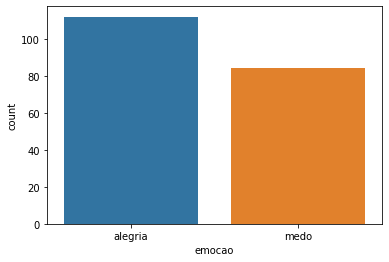

In [5]:
# visualização dos grupos ['emocao']

sns.countplot(treino['emocao'], label='Contagem');

In [6]:
# pre processamento de texto

In [7]:
# pontuações 

pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# stop_words

stop_words = STOP_WORDS

In [9]:
# modelo em portugues

pln = spacy.load('pt')
pln

In [10]:
def processamento(text):
    
    text = text.lower()                  # todos em minuscula para evitar problemas com a lematização
    documento = pln(text)
    lista = []

    # lematização
    for token in documento:
        #lista.append(token.text)
        lista.append(token.lemma_)

    #remoção de stop_words
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

    return lista


In [11]:
teste = processamento('Estou aprendendo liguagem natural com python, em brasilia')
teste

'aprender liguagem natural python brasilia'

In [12]:
# pre processamento da base dados

In [13]:
# visualização da base de dados

treino.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [14]:
# provessamento na base de dados

treino['texto'] = treino['texto'].apply(processamento)

In [15]:
# visualização após o tratamento

treino.head()

,texto,emocao
0,trabalhar agradável,alegria
1,gostar ficar o aconchegar,alegria
2,o adesão o o cursar hoje,alegria
3,admirar,alegria
4,adorar comer,alegria


In [16]:
# tratamento das classes

In [17]:
exemplo_base_dados =[['este trabalho é agradavel', {'ALEGRIA':True, 'MEDO':False}],
                     'este lugar continua assustador', {'ALEGRIA':False, 'MEDO':True}]            

In [18]:
exemplo_base_dados[0]

['este trabalho é agradavel', {'ALEGRIA': True, 'MEDO': False}]

In [19]:
exemplo_base_dados[0][0]

'este trabalho é agradavel'

In [20]:
exemplo_base_dados[0][1]

{'ALEGRIA': True, 'MEDO': False}

In [21]:
type(exemplo_base_dados[0][1])

dict

In [22]:
# deixar a base de dados como no exemplo

In [23]:
treino['emocao']

0      alegria
1      alegria
2      alegria
3      alegria
4      alegria
        ...   
191       medo
192       medo
193       medo
194       medo
195       medo
Name: emocao, Length: 196, dtype: object

In [24]:
# processamento da base de dados

base_dados_final = []

for texto, emocao in zip(treino['texto'], treino['emocao']):
    #print(texto, emocao)
    if emocao == 'alegria':
        dic = ({'ALEGRIA':True, 'MEDO':False})
    elif emocao == 'medo':
        dic = ({'ALEGRIA':False, 'MEDO':True})
    
    base_dados_final.append([texto, dic.copy()])

In [25]:
# verificação após tratamento

base_dados_final[0]

['trabalhar agradável', {'ALEGRIA': True, 'MEDO': False}]

In [26]:
base_dados_final[0][1]

{'ALEGRIA': True, 'MEDO': False}

In [27]:
type(base_dados_final[0][1])

dict

In [28]:
# criação do classificador

In [29]:
# configurações do modelo

model = spacy.blank('pt')

categorias = model.create_pipe('textcat')
categorias.add_label('ALEGRIA')
categorias.add_label('MEDO')

model.add_pipe(categorias)

historico = []

In [30]:
model.begin_training()

for epoch in range(300):  # teste com 1_000 mostrou que significancia até 300
    random.shuffle(base_dados_final)
    losses = {}
    
    for batch in spacy.util.minibatch(base_dados_final, 30):  # quantos registros a atualização dos pesos
        
        textos = [model(texto) for texto, entities in batch]
        
        annotations = [{'cats': entities} for texto, entities in batch]
        
        # atualização dos pesos
        model.update(textos, annotations, losses=losses)
    
    if epoch % 100 == 0:
        print(losses)
        historico.append(losses)


{'textcat': 0.006111857364885509}
{'textcat': 1.1213549733213313e-07}
{'textcat': 3.419905469925766e-08}


In [31]:
# criação de lista com erros para visualização

historico_loss = []
for i in historico:
    historico_loss.append(i.get('textcat'))

In [32]:
# transformação em array

historico_loss = np.array(historico_loss)
historico_loss

array([6.11185736e-03, 1.12135497e-07, 3.41990547e-08])

Text(0, 0.5, 'Erro')

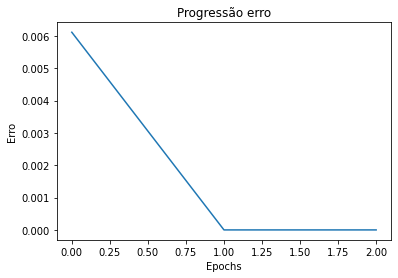

In [33]:
# visualização do erro

plt.plot(historico_loss)
plt.title('Progressão erro')
plt.xlabel('Epochs')
plt.ylabel('Erro')

In [36]:
# salvando modelo

model.to_disk('./data/modelo_spacy_LN')

In [37]:
# carregando modelo

modelo_treinado = spacy.load('./data/modelo_spacy_LN')

In [38]:
# verificação 

modelo_treinado

In [46]:
# teste modelo

texto_positivo = 'eu adoro a cor dos seus olhos'
texto_negativo = 'estou com medo dele'

In [47]:
# preprocessing

texto_positivo = processamento(texto_positivo)
texto_negativo = processamento(texto_negativo)

In [49]:
print(texto_positivo)
print(texto_negativo)

adorar o cor olho
medo d


In [50]:
# previsão positivo

prev = modelo_treinado(texto_positivo)
prev

adorar o cor olho

In [51]:
# visualização positivo

prev.cats

{'ALEGRIA': 0.9976531863212585, 'MEDO': 0.000844139838591218}

In [52]:
# previsão negativo

prev = modelo_treinado(texto_negativo)
prev

medo d

In [53]:
# visualizção negativo

prev.cats

{'ALEGRIA': 0.0006764791905879974, 'MEDO': 0.9998795986175537}

In [54]:
# avaliação do modelo

In [59]:
# lista com previsões na base de treino

previsoes = []

for texto in treino['texto']:
    #print(texto)
    prev_ = modelo_treinado(texto)
    previsoes.append(prev_.cats)

In [60]:
# visualização previsoes

previsoes

[{'ALEGRIA': 0.9994485974311829, 'MEDO': 0.00011876882490469143},
 {'ALEGRIA': 0.9970086216926575, 'MEDO': 0.0018794306088238955},
 {'ALEGRIA': 0.999771773815155, 'MEDO': 0.0003599323390517384},
 {'ALEGRIA': 0.9994340538978577, 'MEDO': 0.00028366746846586466},
 {'ALEGRIA': 0.9999088048934937, 'MEDO': 4.539787187241018e-05},
 {'ALEGRIA': 0.9992040991783142, 'MEDO': 5.979924389976077e-05},
 {'ALEGRIA': 0.9976531863212585, 'MEDO': 0.000844139838591218},
 {'ALEGRIA': 0.9992800354957581, 'MEDO': 0.0006117734010331333},
 {'ALEGRIA': 0.9991470575332642, 'MEDO': 0.0006060979794710875},
 {'ALEGRIA': 0.9991080164909363, 'MEDO': 0.00017572428623680025},
 {'ALEGRIA': 0.9993316531181335, 'MEDO': 0.00046976981684565544},
 {'ALEGRIA': 0.9995914101600647, 'MEDO': 0.00010104260582011193},
 {'ALEGRIA': 0.9997665286064148, 'MEDO': 0.00013284303713589907},
 {'ALEGRIA': 0.99964439868927, 'MEDO': 0.00019938245532102883},
 {'ALEGRIA': 0.9993776679039001, 'MEDO': 0.0001642816059757024},
 {'ALEGRIA': 0.9992395

In [63]:
# transformação das previsoes para avaliação

previsoes_final = []

for previsao in previsoes:

    if previsao['ALEGRIA'] > previsao['MEDO']:
        previsoes_final.append('alegria')
    
    elif previsao['MEDO'] > previsao['ALEGRIA']:
        previsoes_final.append('medo')

previsoes_final = np.array(previsoes_final)

In [64]:
# viz após a transformação

previsoes_final

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [65]:
# transformação para comparação

respostas_reais = treino['emocao'].values
respostas_reais

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [72]:
# acuracia do modelo

accuracy_score(previsoes_final, respostas_reais)

1.0

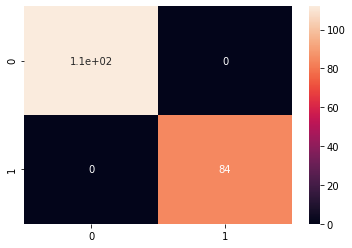

In [73]:
# viz matriz de confusão

cnn = confusion_matrix(previsoes_final, respostas_reais)
sns.heatmap(cnn, annot=True);

In [74]:
# previsões com teste

In [81]:
# processamento na base de teste

bd_teste['texto'] = bd_teste['texto'].apply(processamento)

In [82]:
# respostas na base de teste

previsoes = [ ]

for texto in bd_teste['texto']:

    previsao = modelo_treinado(texto)
    previsoes.append(previsao.cats)

In [83]:
# tratamento das previsões

previsoes_final_test = []

for previsao in previsoes:

    if previsao['ALEGRIA'] > previsao['MEDO']:
        previsoes_final_test.append('alegria')
    
    elif previsao['MEDO'] > previsao['ALEGRIA']:
        previsoes_final_test.append('medo')

previsoes_final_test = np.array(previsoes_final_test)

In [84]:
# transformação valores teste em array 

respostas_reais_test = bd_teste['emocao'].values

In [85]:
# avaliação

In [86]:
# acuracia do modelo na base de teste

accuracy_score(respostas_reais_test, previsoes_final_test)

0.5238095238095238

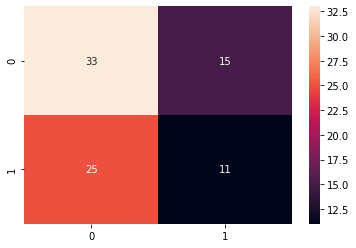

In [90]:
# matriz de confusão

cnn = confusion_matrix(respostas_reais_test, previsoes_final_test)
sns.heatmap(cnn, annot=True);